**STEP 1:**

**Installed Packages:**
- The transformes library from HuggingFace which provides pre-trained language models and the SentencePiece dependency needed for tokenization.
- The datasets library from HuggingFace for easy access to NLP datasets and related functions.
- The Sacrebleu library for evaluating BLEU scores, used for quality evaluation of machine translation.
- The rouge-score library for evaluating ROUGE scores, used for quality evaluation of machine summarization.
- The py7zr library for handeling 7z files.

In [4]:
# Installing the necessary packages and their dependencies
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

In [5]:
# Checking the installed GPUs
!nvidia-smi

Sat May 25 14:16:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
from transformers import pipeline, set_seed
# to be used for creating NLP pipeline and set a random seed for reproducablity.

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric
# to be used for graph-plotting, dataset-loading and data-analysis.

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
# to load pre-trained Seq2Seq models and associated tokenizers.

import nltk
from nltk.tokenize import sent_tokenize
# NLP tool for sentence tokenization.

from tqdm import tqdm
import torch
# importing PyTorch tensors and models

nltk.download("punkt")
# downloading the punkt tokenizer from the NLTK model.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# checking GPU availablity and utilizing it if available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# loading the Pegasus model and its tokenizer from HuggingFace
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# moving the pretrained Pegasus model to "device", assigned above.
model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**STEP 2:**

In [8]:
# defining a helper function to split the data into batch-sized chunks for simultaneous
# processing.
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [9]:
# defining a function for evaluation of the summarization model on the test data.
# The function takes as parameters: the test dataset, the evaluation metric (rouge),
# the summarization model, the model's tokenizer, the batch-size (set to 16), and the
# device to run the model on (set to GPU if available), and the columns of text and
# corresponding summaries.
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size= 8, device=device,
                               column_text="article",
                               column_summary="highlights"):
    model.eval() # Setting the model to evaluation mode.
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))
    # Using the batch-size-generator function defined earlier in order to split the text and
    # summary columns into managable batches for simultaneous processing.

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt").to(device)
        # Tokenizing the input (text coulmn) batches.

        with torch.no_grad():

          summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                                    attention_mask=inputs["attention_mask"].to(device),
                                    length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        # Generating summaries using the pre-trained Pegasus model.

        # decoding the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        # Adding code to clear memory and eliminate RAM problems when running.
        del inputs
        torch.cuda.empty_cache() if device == 'cuda' else None

    # Compute and return the ROUGE scores for model evaluation
    score = metric.compute()
    return score

In [10]:
dataset_samsum = load_dataset("samsum")
# loading the samsum dataset from HuggingFace.

split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]
print(f"Split lengths: {split_lengths}")
# spliting the data using a list comprehension,
# and getting the length of the splits: training, validation, and test.

print(f"Features: {dataset_samsum['train'].column_names}")
# printing the column names in the dataset.

print("\nDialogue:")
print(dataset_samsum["test"][1]["dialogue"])
# printing an example dialouge.

print("\nSummary:")
print(dataset_samsum["test"][1]["summary"])
# printing the corresponding summary of that example.

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:
Eric and Rob are going to watch a stand-up on youtube.


In [11]:
dataset_samsum['test'][0]['dialogue']
# calling the dialouge from the first item of the test split of the data.

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [12]:
pipe = pipeline('summarization', model = model_ckpt )
# Creating a summarizarion pipeline using the transformers library.

pipe_out = pipe(dataset_samsum['test'][0]['dialogue'] )
print(pipe_out)
# Using the pipeline to generate a summary by the pretained model of the test data sample.

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


[{'summary_text': "Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him ."}]


In [13]:
print(pipe_out[0]['summary_text'].replace(" .", ".\n"))
# The generated summary is printed after formatting.

Amanda: Ask Larry Amanda: He called her last time we were at the park together.
<n>Hannah: I'd rather you texted him.
<n>Amanda: Just text him.



In [14]:
rouge_metric = load_metric('rouge')
score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'dialogue', column_summary='summary', batch_size=8)
# Loading the rouge metric and calcualting the scores of the pretrained Pegasus model
# on the test split of the samsum dataset using the calculation funtio defined earlier.

<ipython-input-14-79b47bd2d5a8>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
100%|██████████| 103/103 [19:45<00:00, 11.51s/it]


In [15]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
# Defining the names of the ROUGE metric which are of interest, and extracting the
# fmeasure scores for each of the metrics from the score dictionary.

dataframe_rouge = pd.DataFrame(rouge_dict, index = ['pegasus'])
# Creating a pandas dataframe from the ROUGE dictionary.

print(dataframe_rouge)
# Displaying the ROUGE metrics in a tabular format.

           rouge1    rouge2    rougeL  rougeLsum
pegasus  0.015604  0.000298  0.015554   0.015592


Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


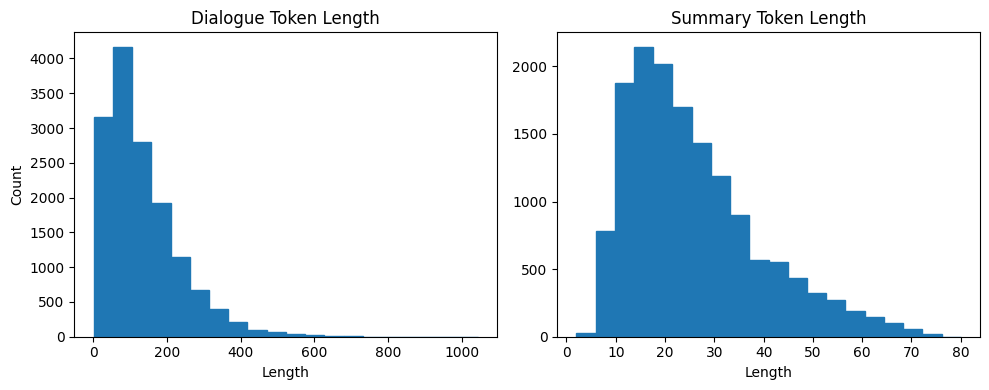

In [16]:
dialogue_token_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['dialogue']]
summary_token_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['summary']]
# Creating lisis containing the lengths of the tokenized dialouges.

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
# Creating a histogram representing the lengths of the tokenized dialouges.

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
# Creating a histogram representing the lengths of the tokenized summaries.

plt.tight_layout()
# Preventing overlap
plt.show()

In [17]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    # Added the following two lines per chatgpt recomendation
    target_encodings['labels'] = target_encodings['input_ids'].copy()
    target_encodings['input_ids'] = [[tokenizer.pad_token_id] + ids[:-1] for ids in target_encodings['input_ids']]

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [18]:
from transformers import DataCollatorForSeq2Seq
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

# Creating a data collector for Seq2Seq tasks, ie dialouge to summary, designed to
# work with the Gegasus model and associated tokenizer.

In [19]:
# Install necessary packages
!pip uninstall transformers accelerate -y
!pip install transformers[torch] accelerate -U

import torch
from transformers import TrainingArguments, Trainer, AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import load_dataset

Found existing installation: transformers 4.41.1
Uninstalling transformers-4.41.1:
  Successfully uninstalled transformers-4.41.1
Found existing installation: accelerate 0.30.1
Uninstalling accelerate-0.30.1:
  Successfully uninstalled accelerate-0.30.1
  Using cached transformers-4.41.1-py3-none-any.whl (9.1 MB)
  Using cached accelerate-0.30.1-py3-none-any.whl (302 kB)


In [20]:
from transformers import TrainingArguments, Trainer
# importing the necessary classes for training a model using the Transformers library.

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)
# Specifiying the training arguments for the model.

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])
# Creating the trainer object to configure the training process for the Pegasus
# model on the Samsum dataset.

In [22]:
trainer.train()
# Initiating the training process

Step,Training Loss,Validation Loss
500,2.205200,1.986345


TrainOutput(global_step=920, training_loss=2.3755770247915518, metrics={'train_runtime': 3038.2435, 'train_samples_per_second': 4.849, 'train_steps_per_second': 0.303, 'total_flos': 5528248038285312.0, 'train_loss': 2.3755770247915518, 'epoch': 0.9991854466467553})

In [23]:
score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
# Calculating the ROUGE metric scores of the Pegasus model after training, using
# the test split of the samsum dataset. Retriving the relevant fmeasure scores using
# the rouge_dict dictionary.

pd.DataFrame(rouge_dict, index = [f'pegasus'])
print(pd.DataFrame(rouge_dict, index=[f'pegasus']))
# Storing the resulting scores in a pandas dataframe and displaying the outcomes.

100%|██████████| 410/410 [16:35<00:00,  2.43s/it]


           rouge1    rouge2    rougeL  rougeLsum
pegasus  0.016092  0.000344  0.015917   0.015963


In [24]:
## Save model
model_pegasus.save_pretrained("pegasus-samsum-model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


In [25]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [26]:
dataset_samsum = load_dataset("samsum")
# loading the SamSum dataset

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [27]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")
# Assigning the tokenizer variable

In [28]:
sample_text = dataset_samsum["test"][0]["dialogue"]

reference = dataset_samsum["test"][0]["summary"]
# Assigning the text and reference to the dialogue and summary columns of the test data,
# respectively.

In [29]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
# defining a dictionary with the parameters for text-generation.

pipe = pipeline("summarization", model="pegasus-samsum-model",tokenizer=tokenizer)
# using the pipleine funtion from HuggingFace's transformers library to generate a
# summerization preprocessing pipeline for the fine-tuned model.

In [30]:
# Looking at a sample summary by our fine-tuned Pegasus model.
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry.
